# Lasso + LGB on weather data

Adapted from https://www.tensorflow.org/tutorials/structured_data/time_series

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import lightgbm as lgb

In [4]:
from scipy import stats
import os
import sys
import pathlib

pd.set_option("display.precision", 2)

In [5]:
from sklearn.metrics import mean_squared_error

In [6]:
path = 'data/weather/'

In [7]:
# data files
file_x_train = "x_train.csv"
file_x_val = "x_val.csv"
file_x_test = "x_test.csv"
file_y_train = "y_train.csv"
file_y_val = "y_val.csv"
file_y_test = "y_test.csv"

In [8]:
x_train = pd.read_csv(f'{path}{file_x_train}', index_col=0)
x_val = pd.read_csv(f'{path}{file_x_val}', index_col=0)
x_test = pd.read_csv(f'{path}{file_x_test}', index_col=0)

y_train = pd.read_csv(f'{path}{file_y_train}', index_col=0).iloc[:,0]
y_val = pd.read_csv(f'{path}{file_y_val}', index_col=0).iloc[:,0]
y_test = pd.read_csv(f'{path}{file_y_test}', index_col=0).iloc[:,0]

In [9]:
x_train.shape, x_val.shape, x_test.shape

((49063, 7), (14018, 7), (7010, 7))

In [10]:
y_train.shape, y_val.shape, y_test.shape

((49063,), (14018,), (7010,))

### Modelling

In [11]:
def print_stats(y, pred):
    
    rmse = np.sqrt(mean_squared_error(y, pred))
    pearson_coef, p_value = stats.pearsonr(y, pred)
    # na_count = y.isna().astype(int).sum() + pd.Series(pred).isna().astype(int).sum()
    
    return rmse, pearson_coef, p_value

### Base Case - Lasso

In [12]:
from sklearn.linear_model import LassoCV, Lasso


In [13]:
# Create a list of alpha values to search over (you can customize this)
alphas = [0.005, 0.01, 0.1, 1.0, 10.0]

# Create a LassoCV model with cross-validation
lasso_cv = LassoCV(alphas=alphas, cv=5)

# Fit the model to the training data
lasso_cv.fit(x_train, y_train)

LassoCV(alphas=[0.005, 0.01, 0.1, 1.0, 10.0], cv=5)

In [14]:
optimal_alpha = lasso_cv.alpha_
print("Optimal Alpha:", optimal_alpha)

Optimal Alpha: 0.01


In [15]:
final_lasso_model = Lasso(alpha=optimal_alpha)
final_lasso_model.fit(x_train, y_train)

Lasso(alpha=0.01)

In [16]:
pred = final_lasso_model.predict(x_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred))

In [17]:
pred_train = final_lasso_model.predict(x_train)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

In [18]:
pred_val = final_lasso_model.predict(x_val)
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))

In [19]:
# Check if there are any na values
y_test.isna().astype(int).sum(), pd.Series(pred).isna().astype(int).sum()

(0, 0)

In [20]:
print_stats(y_test, pred)

(7.733337573741088, 0.3427706173571371, 1.7471769346343802e-192)

In [21]:
print_stats(y_train, pred_train)

(8.087523270951838, 0.3561212181523331, 0.0)

In [22]:
print_stats(y_val, pred_val)

(6.873451194648858, 0.4418126485126906, 0.0)

In [23]:
compare = pd.DataFrame(data=y_test.to_list(), columns=["labels"])

In [24]:
compare["predict"] = pred

In [25]:
compare.iloc[:10]

,labels,predict
0,2.80,6.99
1,2.75,7.33
2,2.46,4.88
3,1.93,5.09
4,1.87,4.39
5,1.93,3.51
6,1.86,2.26
7,1.72,2.33
8,1.60,1.79
9,1.62,2.46


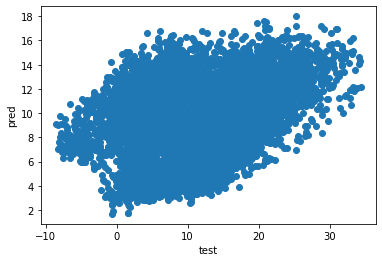

In [26]:
plt.scatter(y_test, pred)
plt.xlabel("test")
plt.ylabel("pred")
plt.show()

### LGB

In [30]:
random_seed = 42

In [31]:
# Create a LightGBM dataset for training
train_data = lgb.Dataset(x_train, label=y_train)
val_data = lgb.Dataset(x_val, label=y_val, reference=train_data)

# Set hyperparameters for the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error
    'boosting_type': 'gbdt',  # Gradient Boosting Decision Tree
    'num_leaves': 31,  # Maximum number of leaves in one tree
    'learning_rate': 0.05,  # Learning rate
    'feature_fraction': 0.9,  # Feature fraction for training
    'seed': random_seed,
}

# Train the LightGBM model
num_boost_round = 100  # Number of boosting rounds (you can adjust this)
bst = lgb.train(params, train_data, num_boost_round=num_boost_round, valid_sets=[val_data], early_stopping_rounds=10)


C:\Users\Sing\anaconda3\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 49063, number of used features: 7
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 9.108207
[1]	valid_0's rmse: 7.58211
Training until validation scores don't improve for 10 rounds
[2]	valid_0's rmse: 7.48536
[3]	valid_0's rmse: 7.4037
[4]	valid_0's rmse: 7.33298
[5]	valid_0's rmse: 7.25699
[6]	valid_0's rmse: 7.19142
[7]	valid_0's rmse: 7.12797
[8]	valid_0's rmse: 7.07102
[9]	valid_0's rmse: 7.02245
[10]	valid_0's rmse: 6.97808
[11]	valid_0's rmse: 6.93304
[12]	valid_0's rmse: 6.90082
[13]	valid_0's rmse: 6.8642
[14]	valid_0's rmse: 6.82587
[15]	valid_0's rmse: 6.79301
[16]	valid_

In [32]:
pred = bst.predict(x_test, num_iteration=bst.best_iteration)
rmse_test = np.sqrt(mean_squared_error(y_test, pred))

In [33]:
pred_train = bst.predict(x_train, num_iteration=bst.best_iteration)
rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))

In [34]:
pred_val = bst.predict(x_val, num_iteration=bst.best_iteration)
rmse_val = np.sqrt(mean_squared_error(y_val, pred_val))

In [35]:
rmse_train, rmse_val, rmse_test

(6.801568450473069, 6.420078893345125, 6.556730593924566)

In [36]:
compare = pd.DataFrame(data=y_test.to_list(), columns=["labels"])

In [37]:
compare["predict"] = pred

In [38]:
compare.iloc[:10]

,labels,predict
0,2.80,6.89
1,2.75,6.73
2,2.46,5.94
3,1.93,5.49
4,1.87,4.74
5,1.93,3.69
6,1.86,3.73
7,1.72,2.98
8,1.60,2.94
9,1.62,2.79


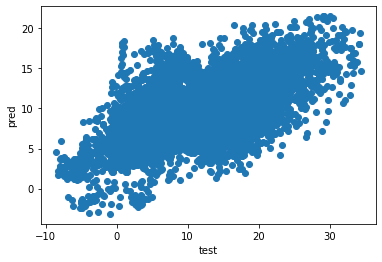

In [39]:
plt.scatter(y_test, pred)
plt.xlabel("test")
plt.ylabel("pred")
plt.show()

In [44]:
print_stats(y_test, pred)

(6.556730593924566, 0.6198775092099104, 0.0)

In [46]:
print_stats(y_val, pred_val)

(6.420078893345125, 0.5439347168545507, 0.0)

In [45]:
print_stats(y_train, pred_train)

(6.801568450473069, 0.6412244058452246, 0.0)